

---


#  🟢 Mapa de Monóxido de Carbono Por Ano Para o Brasil

---
**DADOS**:
- `Acesso aos dados`: [Sentinel-5P NRTI CO: Near Real-Time Carbon Monoxide](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_CO)
- `Período dos dados`: 2018-11-22T12:00:13Z–2025-09-29T13:24:45Z
- `Resolução espacial`: **1113.2 metros**
- `Resolução temporal`: diária


---
**REALIZAÇÃO**:


- Realizado por: Enrique V. Mattos - 30/09/2025
- E-mail: enrique@unifei.edu.br
- GitHub: https://github.com/evmpython
- Lattes: http://lattes.cnpq.br/8010078550088178



---

# **1° Passo:** Preparando ambiente



In [19]:
# instalando bibliotecas
!pip install -q ultraplot cartopy salem xarray dask netCDF4 bottleneck rasterio pyproj geopandas

# importa bibliotecas
import pandas as pd
import numpy as np
import ultraplot as uplt
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import time
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from zipfile import ZipFile
from datetime import datetime
import glob
import xarray as xr
import os
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import salem
import glob
import cartopy.io.shapereader as shpreader
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2° Passo:** Carrega shapefile

In [20]:
# url dos shapefiles
url = 'https://github.com/evmpython/shapefile/raw/main/'

# leitura do shapefile com a biblioteca SALEM
shp_brasil = salem.read_shapefile(f'{url}/brasil/BRAZIL.shp')
#shp_sp = salem.read_shapefile(f'{url}/UFs/SP/SP_UF_2019.shp')

# limites do estado de MG
lonmin, lonmax, latmin, latmax = -52., -39., -23., -14.

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# mostra dados do shapefile do Brasil
shp_brasil

,ScaleRank,LabelRank,FeatureCla,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,GDP_MD_EST,FIPS_10_,ISO_A2,ISO_A3,ISO_N3,geometry,min_x,max_x,min_y,max_y
0,1,2,Adm-0 country,Brazil,BRA,0.0,2.0,Sovereign country,Brazil,BRA,...,1993000.0,0.0,BR,BRA,76.0,"MULTIPOLYGON (((-48.54186 -27.8167, -48.55117 ...",-74.018475,-28.876346,-33.74228,5.267225


# **3° Passo:**  Inicializando o Google Earth Engine

In [21]:
# instalando bibliotecas
!pip install -q xee

# importando bibliotecas
import ee, geemap, xee

# inicializando GEE
geemap.ee_initialize(project='ee-enrique',
                     opt_url='https://earthengine-highvolume.googleapis.com')

# **4° Passo:**  Mapa interativo
- `Agosto de 2024` tem `274 imagens` interceptando o Brasil

In [4]:
%%time
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#estado_mg = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais'))
#municipio_itajuba = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Itajuba'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
# data de referência
data_referencia = '2024-08-01'

# data atual
data_inicial = ee.Date(data_referencia)

# data do próximo mês
data_final = data_inicial.advance(1, 'month')

# imprime na tela
data_string_i = data_inicial.format('YYYY-MM-dd')
data_string_f = data_final.format('YYYY-MM-dd')
print('#-------------------------------------------#')
print('Data Inicial:', data_string_i.getInfo())
print('Data Final', data_string_f.getInfo())
print('#-------------------------------------------#')

# carrega os dados
S5P_co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
           .filterDate(data_inicial, data_final) \
           .select('CO_column_number_density') \
           .filterBounds(brasil)

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura do mapa
Map = geemap.Map(basemap = 'SATELLITE')

# centraliza o mapa na região
Map.centerObject(brasil, 4)

# parâmetros de visualização
param_vis = {'min': 0, 'max': 300, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# plota mapa.
Map.addLayer(S5P_co.max().clip(brasil).multiply(2241.15), param_vis, 'Monóxido de Carbono (CO)')

# contorno da região
style1 = {'color': 'red', 'fillColor': '00000000'}
Map.addLayer(brasil.style(**style1), {}, 'Brasil')

# barra de cores
Map.add_colorbar_branca(colors=param_vis['palette'], vmin=param_vis['min'], vmax=param_vis['max'], layer_name='CO (DU)')
#Map.add_colorbar(param_vis, label='Monóxido de Carbono (DU)', orientation='vertical')

# exibe na tela
Map

#-------------------------------------------#
Data Inicial: 2024-08-01
Data Final 2024-09-01
#-------------------------------------------#
CPU times: user 251 ms, sys: 13.1 ms, total: 264 ms
Wall time: 52.3 s


Map(center=[-10.613275552794567, -53.19823757236853], controls=(WidgetControl(options=['position', 'transparen…

In [7]:
%%time
# mostra datas
datas = pd.DataFrame(ee.List(S5P_co.aggregate_array('system:time_start')) \
                    .map(lambda d: ee.Date(d).format('YYYY-MM-dd HH:mm')) \
                    .getInfo())
datas

CPU times: user 8.04 ms, sys: 94 µs, total: 8.14 ms
Wall time: 36.2 s


,0
0,2024-08-01 15:26
1,2024-08-01 15:31
2,2024-08-01 17:01
3,2024-08-01 17:06
4,2024-08-01 17:11
...,...
269,2024-08-31 17:37
270,2024-08-31 17:42
271,2024-08-31 17:47
272,2024-08-31 17:52


In [9]:
# pega as imagens do dia primeiro. Ou seja, em 1 dia de dados, 9 imagens interceptam o Brasil
datas[0:10]

,0
0,2024-08-01 15:26
1,2024-08-01 15:31
2,2024-08-01 17:01
3,2024-08-01 17:06
4,2024-08-01 17:11
5,2024-08-01 17:16
6,2024-08-01 18:46
7,2024-08-01 18:51
8,2024-08-01 18:56
9,2024-08-02 15:06


# **5° Passo:**  Dados para o mês de Agosto de 2024: `1 mês`

In [13]:
%%time
# shapefile do Brasil
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))

# data de referência
data_referencia = '2024-08-01'

# data atual
data_inicial = ee.Date(data_referencia)

# data do próximo mês
data_final = data_inicial.advance(1, 'month')

# carregando a coleção de dados de CO do Sentinel-5P
co_mensal = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
              .filterDate(data_inicial, data_final) \
              .select(['CO_column_number_density'] , ['co']) \
              .map(lambda img: img.clip(brasil).copyProperties(img, ['system:time_start'])) \
              .map(lambda img: img.multiply(2241.15).copyProperties(img, ['system:time_start'])) \
              .max()

# gera dataset
ds = xr.open_dataset(co_mensal,
                     engine = 'ee',
                     crs = 'EPSG:4326',
                     scale = 0.20,
                     geometry = brasil.geometry())

# muda de "(time, lon, lat)" para "(time, lat, lon)"
ds = ds.transpose("time", "lat", "lon")

# salva arquivo
ds.to_netcdf(f'{dir}/output/codigo_01/1_mes_S5P_co_brasil_20km_{data_referencia[0:7]}.nc')

CPU times: user 63.9 ms, sys: 10.1 ms, total: 73.9 ms
Wall time: 34.3 s


In [15]:
# mostra o dataset
dsx = xr.open_dataset(f'{dir}/output/codigo_01/S5P_co_brasil_20km_{data_referencia[0:7]}.nc')
dsx

<xarray.Dataset> Size: 180kB
Dimensions:  (time: 1, lat: 195, lon: 226)
Coordinates:
  * time     (time) int64 8B 0
  * lon      (lon) float64 2kB -73.89 -73.69 -73.49 ... -29.29 -29.09 -28.89
  * lat      (lat) float64 2kB -33.65 -33.45 -33.25 -33.05 ... 4.75 4.95 5.15
Data variables:
    co       (time, lat, lon) float32 176kB ...
Attributes:
    crs:      EPSG:4326

In [11]:
# mostra o dataset
dsx = xr.open_dataset(f'{dir}/output/codigo_01/S5P_co_brasil_20km_{data_referencia[0:7]}.nc')
dsx

<xarray.Dataset> Size: 180kB
Dimensions:  (time: 1, lat: 195, lon: 226)
Coordinates:
  * time     (time) int64 8B 0
  * lon      (lon) float64 2kB -73.89 -73.69 -73.49 ... -29.29 -29.09 -28.89
  * lat      (lat) float64 2kB -33.65 -33.45 -33.25 -33.05 ... 4.75 4.95 5.15
Data variables:
    co       (time, lat, lon) float32 176kB ...
Attributes:
    crs:      EPSG:4326

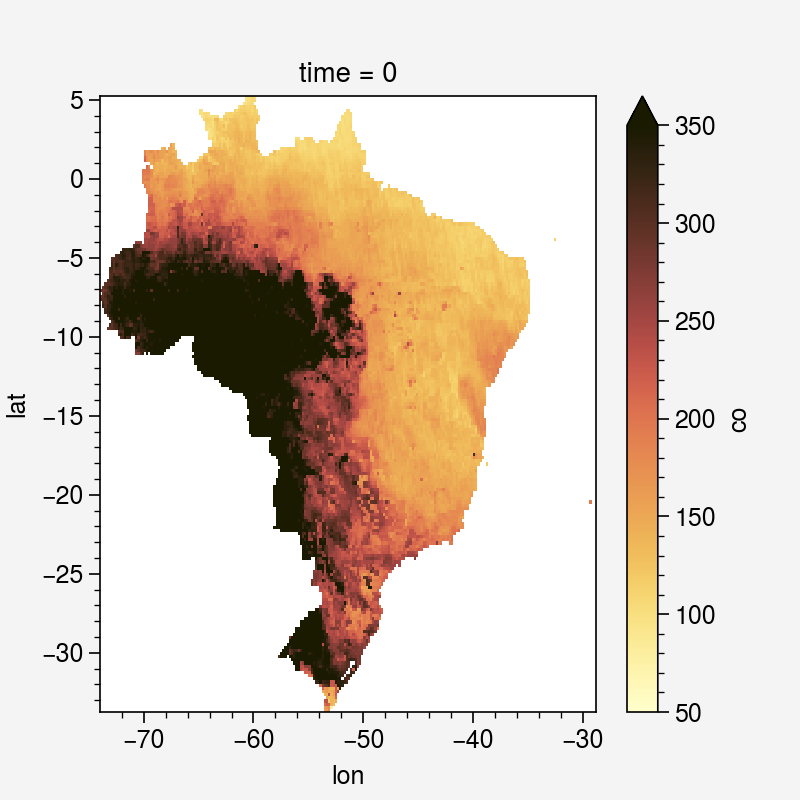

In [12]:
# plota figura
dsx['co'].plot(vmin=50, vmax=350, cmap='lajolla')

# **6° Passo:**  Dados mensais para os anos de 2019 à 2025

## Gera arquivos netcdf mensais
- Para processar `1 ano` de dados gasta `9min e 11s`.

- Para processar `7 anos (2019 à 2025)` de dados gasta `43min e 51s`.

In [26]:
%%time
# shapefile do Brasil
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))

# data inicial
data_inicial = '2019-01-01'
data_inicial = '2025-08-01'

# data final
data_final = '2025-09-01'

# loop dos anos
for file in pd.date_range(data_inicial.replace('-', ''), data_final.replace('-', ''), freq='1m'):

    # extrai ano e mês
    ano = file.strftime('%Y')
    mes = file.strftime('%m')

    print('#-------------------------------------------#')
    print(f' PROCESSANDO =====>>>>: {ano}-{mes}')
    print('#-------------------------------------------#')

    # monta data no formato "2024-01-01"
    date = f"{ano}-{mes}-{file.strftime('%d')}"

    # mês atual
    mes_atual = ee.Date(date)

    # próximo mês
    mes_prox = mes_atual.advance(1, 'month')

    # carregando a coleção de dados de CO do Sentinel-5P
    co_mensal = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
                  .filterDate(mes_atual, mes_prox) \
                  .select(['CO_column_number_density'] , ['co']) \
                  .map(lambda img: img.clip(brasil).copyProperties(img, img.propertyNames()))\
                  .map(lambda img: img.multiply(2241.15).copyProperties(img, ['system:time_start'])) \
                  .max()

    # gera dataset
    ds = xr.open_dataset(co_mensal,
                         engine = 'ee',
                         crs = 'EPSG:4326',
                         scale = 0.20,
                         geometry = brasil.geometry())

    # muda de "(time, lon, lat)" para "(time, lat, lon)"
    ds = ds.transpose("time", "lat", "lon")

    # salva arquivo
    ds.to_netcdf(f'{dir}/output/codigo_01/S5P_co_brasil_20km_{ano}-{mes}.nc')

#-------------------------------------------#
 PROCESSANDO =====>>>>: 2025-08
#-------------------------------------------#
CPU times: user 84.1 ms, sys: 12.3 ms, total: 96.4 ms
Wall time: 56.9 s


In [ ]:
dsx = xr.open_dataset(f'{dir}/output/codigo_01/S5P_co_brasil_50km_2024-08.nc')
dsx

In [ ]:
# plota figura
dsx['co'].plot(vmin=50, vmax=350, cmap='lajolla')

In [ ]:
ds

## Acumula os dados por ano

In [27]:
%%time
# loop dos anos
for file in pd.date_range('20190101', '20251231', freq='1Y'):

    # extrai ano e mês
    ano = file.strftime('%Y')
    print(f' PROCESSANDO =====>>>>: {ano}')

    # lista dos arquivos
    files = sorted(glob.glob(f'{dir}/output/codigo_01/S5P_co_brasil_20km_{ano}-*.nc'))

    # leitura dos arquivos
    ds_anual = xr.open_mfdataset(files, concat_dim='time', combine='nested') # /content/S5P_co_brasil_50km_2019-01.nc

    # calcula o máximo valor
    ds_anual = ds_anual.max(dim='time')

    # salva arquivo
    ds_anual.to_netcdf(f'{dir}/output/codigo_01/anual_S5P_co_brasil_20km_{ano}.nc')

 PROCESSANDO =====>>>>: 2019
 PROCESSANDO =====>>>>: 2020
 PROCESSANDO =====>>>>: 2021
 PROCESSANDO =====>>>>: 2022
 PROCESSANDO =====>>>>: 2023
 PROCESSANDO =====>>>>: 2024
 PROCESSANDO =====>>>>: 2025
CPU times: user 731 ms, sys: 110 ms, total: 841 ms
Wall time: 2.28 s


In [28]:
# arquivos
files

['/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono/output/codigo_01/S5P_co_brasil_20km_2025-01.nc',
 '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono/output/codigo_01/S5P_co_brasil_20km_2025-02.nc',
 '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono/output/codigo_01/S5P_co_brasil_20km_2025-03.nc',
 '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono/output/codigo_01/S5P_co_brasil_20km_2025-04.nc',
 '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono/output/codigo_01/S5P_co_brasil_20km_2025-05.nc',
 '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono/output/codigo_01/S5P_co_brasil_20km_2025-06.nc',
 '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono/output/codigo_01/S5P_co_brasil_20km_2025-07.nc',
 '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/05_monoxido_de_carbono/output/codigo_01/S5P_co_brasil_20km_2025-

In [ ]:
# mostra os dados
ds_anual

## Plota figura

In [29]:
ds

<xarray.Dataset> Size: 180kB
Dimensions:  (time: 1, lon: 226, lat: 195)
Coordinates:
  * time     (time) int64 8B 0
  * lon      (lon) float64 2kB -73.89 -73.69 -73.49 ... -29.29 -29.09 -28.89
  * lat      (lat) float64 2kB -33.65 -33.45 -33.25 -33.05 ... 4.75 4.95 5.15
Data variables:
    co       (time, lat, lon) float32 176kB ...
Attributes:
    crs:      EPSG:4326

Processando o ano: .... 0 2020
Processando o ano: .... 1 2021
Processando o ano: .... 2 2022
Processando o ano: .... 3 2023
Processando o ano: .... 4 2024
Processando o ano: .... 5 2025
CPU times: user 36.5 s, sys: 1.3 s, total: 37.9 s
Wall time: 41.5 s


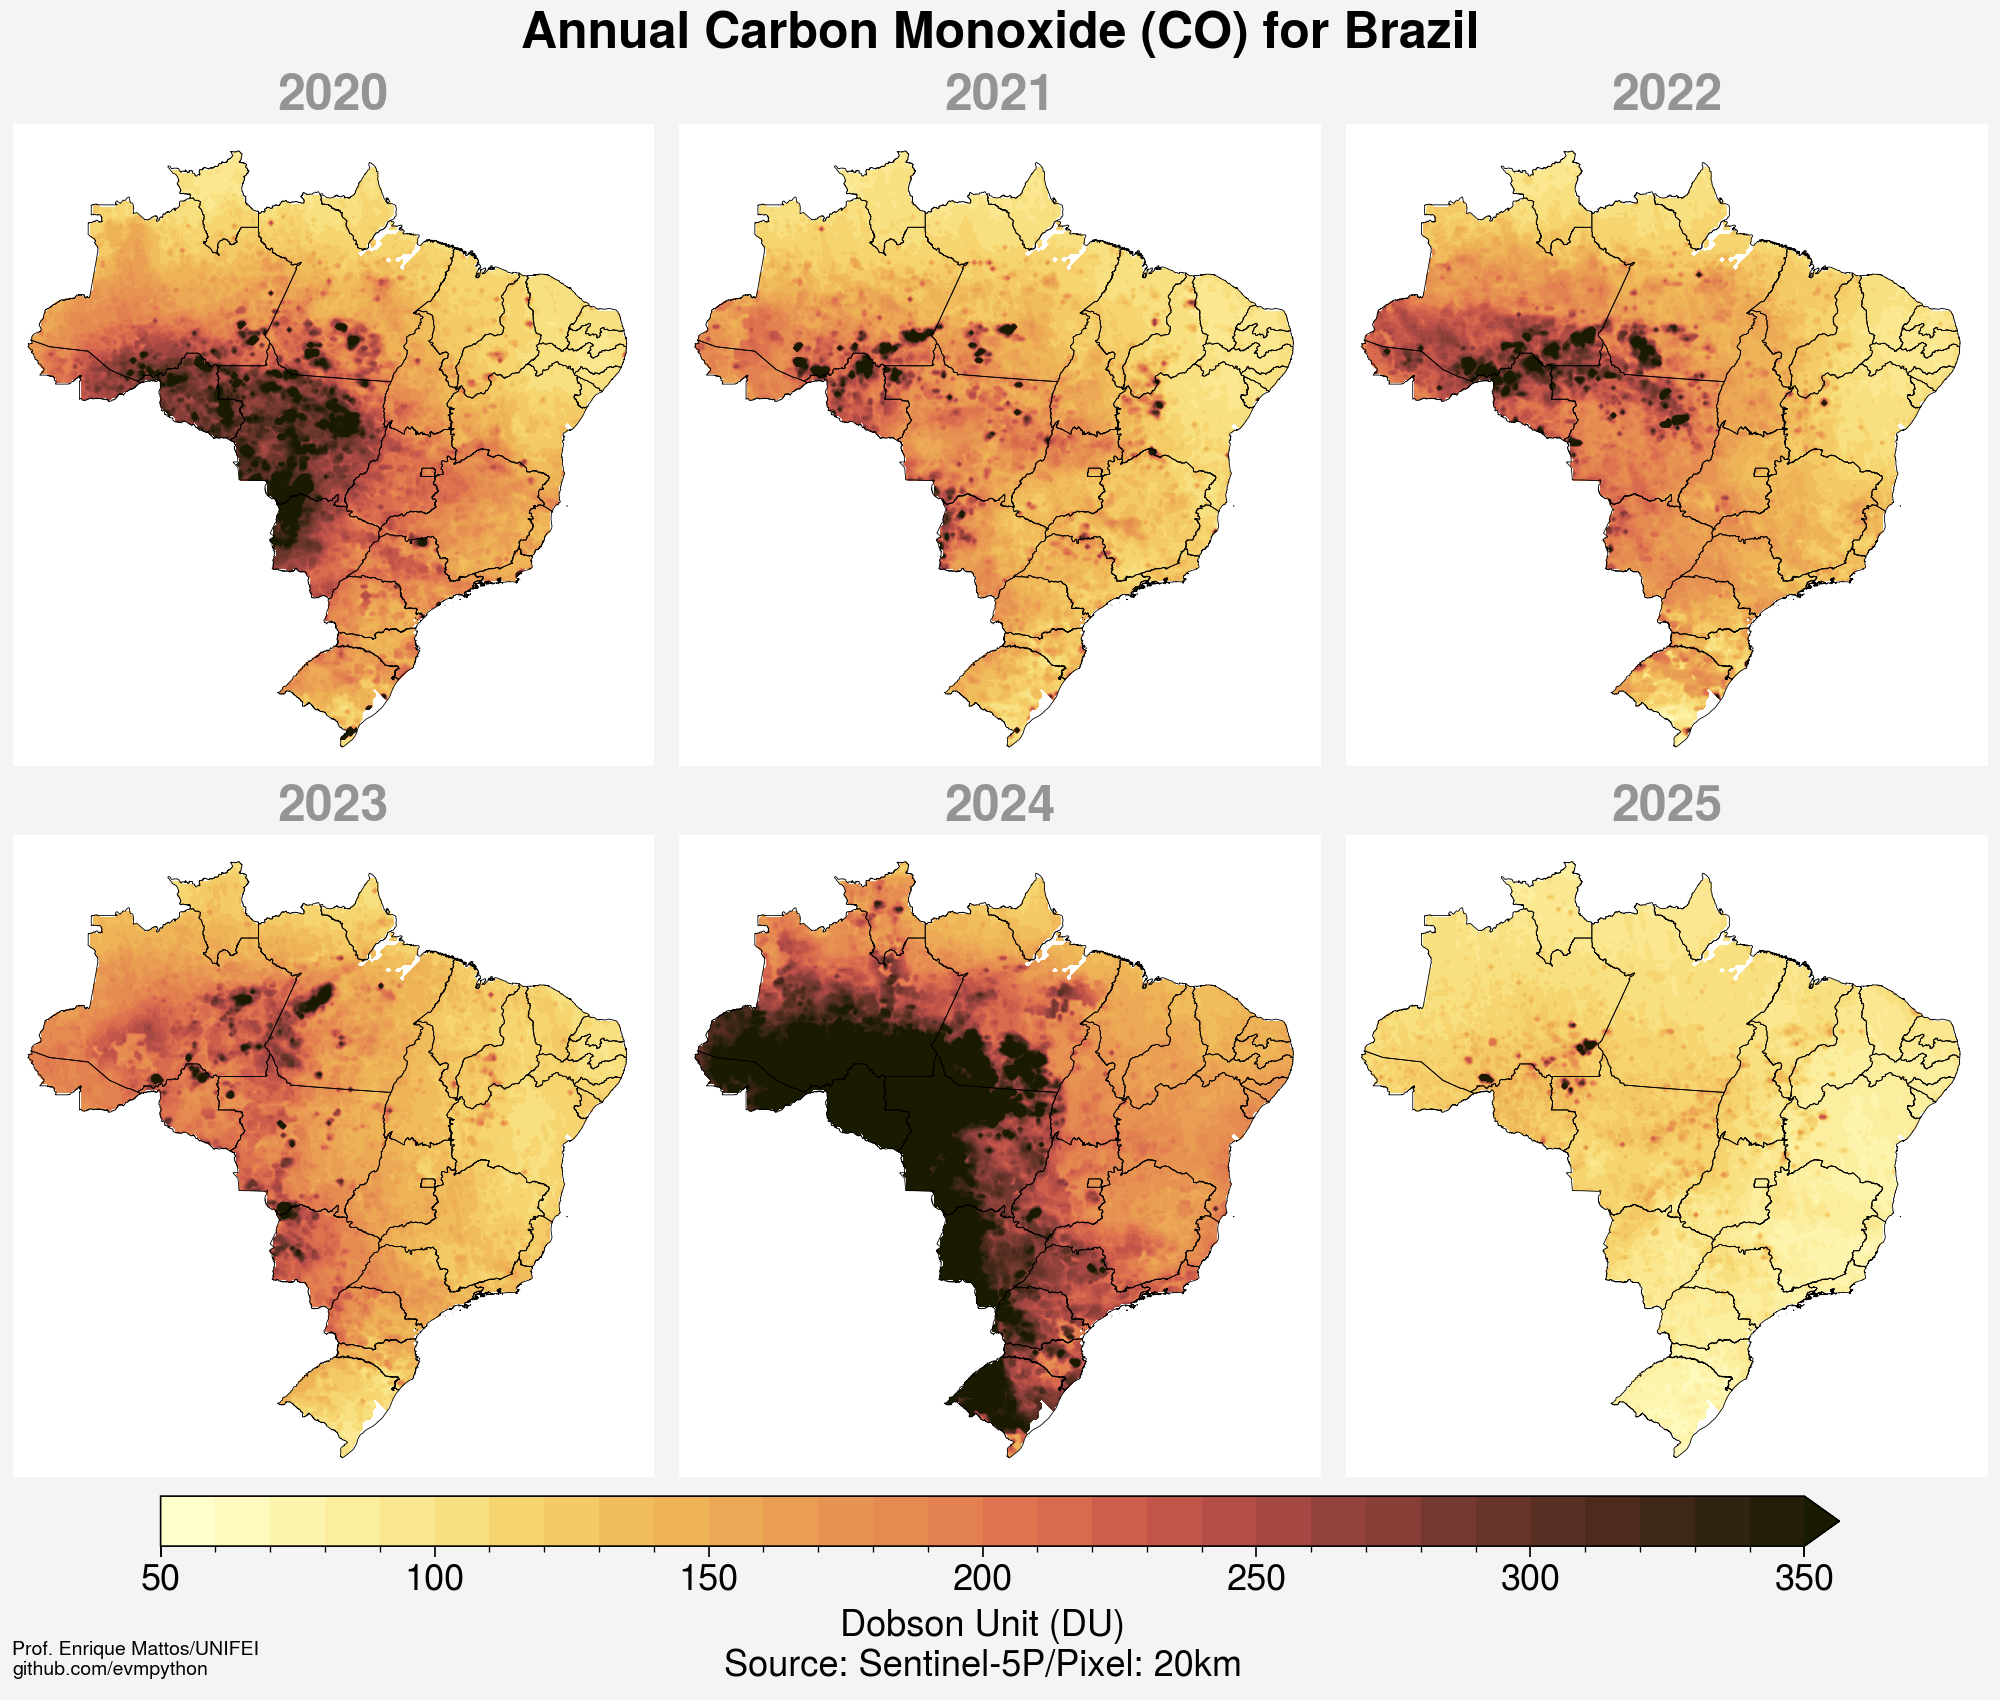

In [31]:
%%time
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(10, 8.5),
                        nrows=2, ncols=3,
                        tight=True,
                        proj='pcarree',
                        sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          suptitle=f'Annual Carbon Monoxide (CO) for Brazil',
          small='20px', large='25px',
          linewidth=0, grid=False)

# loop dos anos
for i, ano in enumerate(np.arange(2020, 2026)):

  # exibe na tela o ano que esta sendo processado
  print(f'Processando o ano: .... {i} {ano}')

  # leitura do arquivo netcdf
  ds = xr.open_dataset(f'{dir}/output/codigo_01/anual_S5P_co_brasil_20km_{ano}.nc') # anual_S5P_co_brasil_20km_2019.nc

  # plota figura
  map1 = ax[i].contourf(ds['lon'],
                        ds['lat'],
                        ds['co'][:,:].salem.roi(shape=shp_brasil),
                        cmap='lajolla',
                        vmin=50, vmax=350,
                        levels=uplt.arange(50, 350, 10),
                        extend='max')

  # plota titulo de cada figura
  ax[i].format(title=str(ano), labels = False, titleloc='c', titlecolor='grey', titleweight='bold')

  # plota contornos. Tempo= 9min 10s
  #estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
  #estados_brasil.plot(edgecolor='black', facecolor='none', linewidth=0.5, alpha=1, ax=ax[i])

  # ou. Tempo=2min 43s
  shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp').geometries())
  ax[i].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.3)

# informação na figura
ax[3].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin-13), fontsize=7, color='black')

# plota barra de cores da figura
fig.colorbar(map1,
             loc='b',
             label='Dobson Unit (DU)\nSource: Sentinel-5P/Pixel: 20km',
             ticks=50,
             ticklabelsize=13,
             labelsize=13,
             length=0.85,
             width=0.25,
             space=0.0)

# salva figura
fig.savefig(f'{dir}/output/codigo_01/Fig_S5P_CO_anual_Brasil_2020_to_2025_20km.jpg', transparent=True, dpi=300, bbox_inches="tight")